In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from keras.layers import Dropout

import os
from absl import app

assert tf.__version__.startswith('2')

In [2]:
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

TensorFlow version: 2.9.1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


100%|███████████████████████████████████████| 754/754 [00:00<00:00, 2618.15it/s]


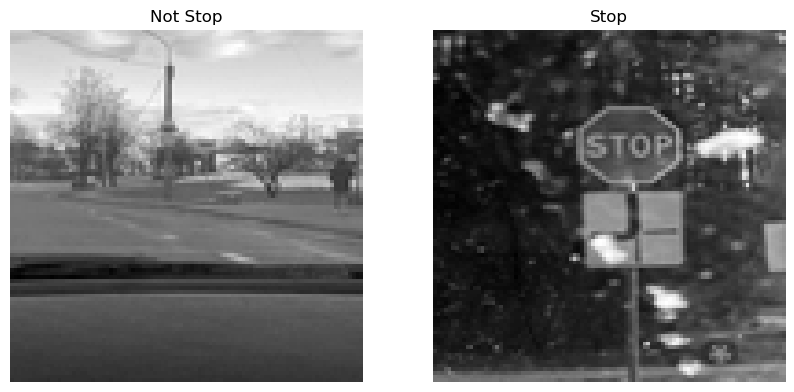

In [3]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the saved model
#model = tf.keras.models.load_model('my_model.h5')

# Define image dimensions
IMG_WIDTH = 96
IMG_HEIGHT = 96

# Define file paths for dataset
not_stop_path = './Datasets/Dataset/not_stop/*.png'
stop_path = './Datasets/Dataset/stop/*.png'

# Define function to load and preprocess image
def load_and_preprocess_image(filepath):
    # Load image as grayscale
    img = load_img(filepath, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    # Convert image to numpy array
    img = img_to_array(img)
    # Normalize pixel values
    img = img / 255.0
    return img

# Load images and labels into lists
not_stop_images = []
stop_images = []
not_stop_labels = []
stop_labels = []

for filepath in tqdm(tf.io.gfile.glob(not_stop_path)):
    not_stop_images.append(load_and_preprocess_image(filepath))
    not_stop_labels.append(1)

for filepath in tqdm(tf.io.gfile.glob(stop_path)):
    stop_images.append(load_and_preprocess_image(filepath))
    stop_labels.append(0)

# Concatenate images and labels
images = not_stop_images + stop_images
labels = not_stop_labels + stop_labels

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Display one image from each class with label
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(not_stop_images[1], cmap='gray')
plt.axis('off')
plt.title('Not Stop')
plt.subplot(1,2,2)
plt.imshow(stop_images[1], cmap='gray')
plt.axis('off')
plt.title('Stop')
plt.show()

In [4]:
import random
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
random.seed(42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

# Convert data to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


2023-04-04 19:10:51.186549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 19:10:51.187207: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [37]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D, Dropout, MaxPooling2D, Flatten, Dense

def build_binary_model():
    input_shape = (96, 96, 1)
    #l2_value=0.0005
    l2_value=0.01
    model = tf.keras.Sequential([
        Input(shape=input_shape, name='input'),
        Conv2D(32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='conv1'),
        BatchNormalization(name='batch1'),
        Dropout(0.3),  # add dropout layer

        DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv2'),
        Conv2D(64, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv2'),
        BatchNormalization(name='batch2'),
        Dropout(0.3),  # add dropout layer

        DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv3'),
        Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv3'),
        BatchNormalization(name='batch3'),
        Dropout(0.3),  # add dropout layer
        
        DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv4'),
        Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv4'),
        BatchNormalization(name='batch4'),
        Dropout(0.3),  # add dropout layer
        
        DepthwiseConv2D(kernel_size=(3,3), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv5'),
        Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv5'),
        BatchNormalization(name='batch5'),
        Dropout(0.3),  # add dropout layer
        
        DepthwiseConv2D(kernel_size=(3,3), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv6'),
        Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv6'),
        BatchNormalization(name='batch6'),
        Dropout(0.3),  # add dropout layer

        DepthwiseConv2D(kernel_size=(3,3), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv7'),
        Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv7'),
        BatchNormalization(name='batch7'),
#         Dropout(0.3),  # add dropout layer
        
#         DepthwiseConv2D(kernel_size=(3,3), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv8'),
#         Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv8'),
#         BatchNormalization(name='batch8'),
#         Dropout(0.3),  # add dropout layer

#         DepthwiseConv2D(kernel_size=(3,3), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv9'),
#         Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv9'),
#         BatchNormalization(name='batch9'),
#         Dropout(0.3),  # add dropout layer
        
#         DepthwiseConv2D(kernel_size=(3,3), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv10'),
#         Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv10'),
#         BatchNormalization(name='batch10'),
        
        #finishing layers
        MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool'),
        Flatten(name='flatten'),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_value), name='dense1'),
        Dense(2, activation='softmax', name='output')
    ], name='binary_model')
    
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
#    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.2, mode='min')
    
    return model#, early_stop

In [38]:
model = build_binary_model()
model.summary()

Model: "binary_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 48, 48, 32)        320       
                                                                 
 batch1 (BatchNormalization)  (None, 48, 48, 32)       128       
                                                                 
 dropout_24 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 depth_conv2 (DepthwiseConv2  (None, 24, 24, 32)       320       
 D)                                                              
                                                                 
 point_conv2 (Conv2D)        (None, 24, 24, 64)        2112      
                                                                 
 batch2 (BatchNormalization)  (None, 24, 24, 64)       256       
                                                      

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SeparableConv2D

lr=0.01

In [40]:
# # Train the model with early stopping
model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))
#history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/50
31/31 [==============================] - 3s 66ms/step - loss: 7.5948 - accuracy: 0.6154 - val_loss: 7.2883 - val_accuracy: 0.5113
Epoch 2/50
31/31 [==============================] - 2s 60ms/step - loss: 7.0644 - accuracy: 0.6761 - val_loss: 6.9447 - val_accuracy: 0.5113
Epoch 3/50
31/31 [==============================] - 2s 61ms/step - loss: 6.6846 - accuracy: 0.7034 - val_loss: 6.6007 - val_accuracy: 0.5113
Epoch 4/50
31/31 [==============================] - 2s 68ms/step - loss: 6.2658 - accuracy: 0.7439 - val_loss: 6.2585 - val_accuracy: 0.5113
Epoch 5/50
31/31 [==============================] - 2s 61ms/step - loss: 5.9125 - accuracy: 0.7713 - val_loss: 5.9279 - val_accuracy: 0.5113
Epoch 6/50
31/31 [==============================] - 2s 57ms/step - loss: 5.5608 - accuracy: 0.7743 - val_loss: 5.6097 - val_accuracy: 0.5113
Epoch 7/50
31/31 [==============================] - 2s 64ms/step - loss: 5.2497 - accuracy: 0.7824 - val_loss: 5.3070 - val_accuracy: 0.4887
Epoch 8/50
31

In [41]:
# Get the number of trainable parameters
num_params = model.count_params()

print("Number of trainable parameters:", num_params)

Number of trainable parameters: 90018


In [42]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

# Save the results to a text file
with open(f"./figs/{num_params}_results.txt", "w") as file:
    file.write(f"Number of trainable parameters: {num_params}\n")
    file.write(f"Validation loss: {val_loss}\n")
    file.write(f"Validation accuracy: {val_accuracy}\n")

8/8 [==============================] - 0s 8ms/step - loss: 0.5346 - accuracy: 0.9032
Validation loss: 0.5345594882965088
Validation accuracy: 0.9032257795333862


In [43]:
import tensorflow as tf

# Define the custom target label
custom_target = 1

# Predict labels for validation set
y_val_pred = model.predict(X_val)

# Convert predicted and actual labels to binary form for the custom target
y_val_pred_binary = tf.where(y_val_pred[:, custom_target] >= 0.5, 1, 0)
y_val_binary = tf.where(y_val[:, custom_target] >= 0.5, 1, 0)

# Compute confusion matrix for the custom target
confusion_matrix = tf.math.confusion_matrix(y_val_binary, y_val_pred_binary)

# Calculate False Rejection Rate (FRR) and False Positive Rate (FPR) for the custom target
tn, fp, fn, tp = confusion_matrix.numpy().ravel()
frr = fn / (fn + tp)
fpr = fp / (fp + tn)

print(f"False Rejection Rate (FRR): {frr}")
print(f"False Positive Rate (FPR): {fpr}")

8/8 [==============================] - 0s 6ms/step
False Rejection Rate (FRR): 0.14960629921259844
False Positive Rate (FPR): 0.04132231404958678


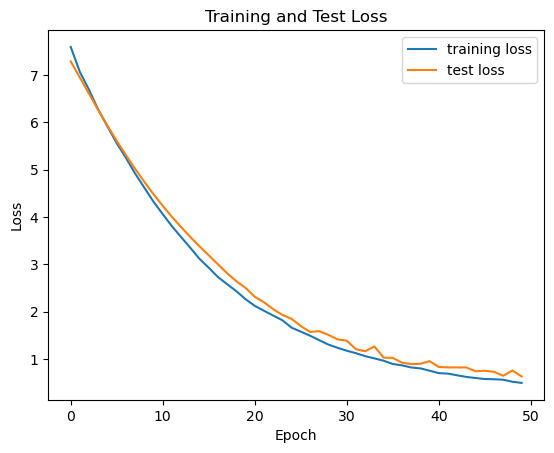

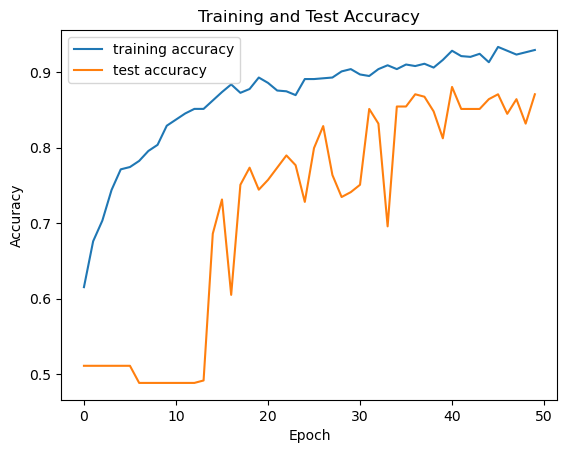

In [44]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'./figs/{num_params}_loss.png')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'./figs/{num_params}_accuracy.png')
plt.show()

In [46]:
import os
import shutil

# Round the number of trainable parameters to the nearest thousand and format as a string with a "k" suffix
num_params_rounded = str(round(num_params / 1000)) + "k"

# Create a directory for the results
results_dir = f"./figs/{num_params_rounded}/"
os.makedirs(results_dir, exist_ok=True)

# Save the figures in the results directory
num_files_moved = 0
for filename in os.listdir("./figs/"):
    if filename.startswith(str(num_params)):
        shutil.move(f"./figs/{filename}", results_dir)
        num_files_moved += 1

print(f"Moved {num_files_moved} files to {results_dir}")

Moved 3 files to ./figs/90k/


In [47]:
model.save(f"./models/smaller_model_{num_params_rounded}.h5")

In [48]:
import os
import tensorflow as tf

BASE_DIR = os.path.join(os.getcwd(), "./models/")


def main(model_file):
    model = tf.keras.models.load_model(model_file)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    tflite_float_model = converter.convert()
    with open(os.path.join(BASE_DIR, f'smaller_model_{num_params_rounded}_float.tflite'), 'wb') as f:
        f.write(tflite_float_model)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    def representative_dataset_gen():
        stop_dir = os.path.join("./Datasets/Dataset", "stop")
        not_stop_dir = os.path.join("./Datasets/Dataset", "not_stop")
        for idx, folder in enumerate([stop_dir, not_stop_dir]):
            for image_file in os.listdir(folder):
                if idx > 10:
                    return
                full_path = os.path.join(folder, image_file)
                if os.path.isfile(full_path):
                    img = tf.keras.preprocessing.image.load_img(
                        full_path, color_mode='grayscale').resize((96, 96))
                    arr = tf.keras.preprocessing.image.img_to_array(img)
                    yield [arr.reshape(1, 96, 96, 1) / 255.]

    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_quantized_model = converter.convert()
    with open(os.path.join(BASE_DIR, f'smaller_model_{num_params_rounded}_int8.tflite'), 'wb') as f:
        f.write(tflite_quantized_model)


if __name__ == '__main__':
    model_file = os.path.join(BASE_DIR, f'smaller_model_{num_params_rounded}.h5')
    main(model_file)


INFO:tensorflow:Assets written to: /tmp/tmpa55b15_g/assets


INFO:tensorflow:Assets written to: /tmp/tmpa55b15_g/assets
2023-04-04 19:20:48.641535: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-04 19:20:48.641554: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-04 19:20:48.641644: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpa55b15_g
2023-04-04 19:20:48.645917: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-04-04 19:20:48.645941: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpa55b15_g
2023-04-04 19:20:48.664980: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-04-04 19:20:48.792573: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpa55b15_g
2023-04-04 19:20:48.838742: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpijc8gp66/assets


INFO:tensorflow:Assets written to: /tmp/tmpijc8gp66/assets
/home/david/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-04-04 19:21:00.561879: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-04 19:21:00.561898: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-04 19:21:00.561990: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpijc8gp66
2023-04-04 19:21:00.566827: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-04-04 19:21:00.566843: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpijc8gp66
2023-04-04 19:21:00.583466: I tensorflow/cc/saved_model/loader.c

In [49]:
%cd ./models/
!ls

/home/david/Documents/GitHub/project-1-team-1/training/models
model_data.ccp			 smaller_model_145k_int8.tflite
smaller_model_108k_float.tflite  smaller_model_72k_float.tflite
smaller_model_108k.h5		 smaller_model_72k.h5
smaller_model_108k_int8.tflite	 smaller_model_72k_int8.tflite
smaller_model_127k.h5		 smaller_model_90k_float.tflite
smaller_model_145k_float.tflite  smaller_model_90k.h5
smaller_model_145k.h5		 smaller_model_90k_int8.tflite


In [50]:
!xxd -i smaller_model_90k_int8.tflite  > model_data.ccp

In [51]:
%cd /home/david/Documents/GitHub/project-1-team-1/training/

/home/david/Documents/GitHub/project-1-team-1/training


In [52]:
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=f"./models/smaller_model_{num_params_rounded}_int8.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print model summary
print("Model Summary:")
print("--------------")
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Model Summary:
--------------
Input Shape: [ 1 96 96  1]
Input Type: <class 'numpy.int8'>
Output Shape: [1 2]
Output Type: <class 'numpy.int8'>


In [53]:
import os
import random
import shutil
from PIL import Image

source_dirs = ['./Datasets/Dataset/not_stop', './Datasets/Dataset/stop']

for source_dir in source_dirs:
    # Get a list of image files in the source directory
    image_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Choose a random image file from the list
    image_file = random.choice(image_files)

    # Open the image file and convert to grayscale
    image = Image.open(os.path.join(source_dir, image_file)).convert('L')

    # Resize the image to 96x96
    image = image.resize((96, 96))

    # Copy the image file to the current directory and rename it
    if source_dir.endswith('not_stop'):
        image.save('./not_stop.png')
    elif source_dir.endswith('stop'):
        image.save('./stop.png')


In [54]:
import tensorflow as tf
import numpy as np
from PIL import Image
import time 
# Load model

model = tf.keras.models.load_model(f"./models/smaller_model_{num_params_rounded}.h5")

# Load image and preprocess
image = Image.open("./stop.png").convert("L")
image = np.array(image.resize((96, 96)))
image = image / 255.0
image = image.reshape((1, 96, 96, 1))

# Run inference and measure time taken
start_time = time.time()
output = model.predict(image)
inference_time = time.time() - start_time

# Print inference results and time taken
print("Stop Score:", output[0][0])
print("Not Stop Score:", output[0][1])
print("Inference time:", inference_time)

1/1 [==============================] - 0s 136ms/step
Stop Score: 0.87312776
Not Stop Score: 0.12687221
Inference time: 0.15497875213623047


In [55]:
import tensorflow as tf
import numpy as np
from PIL import Image
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=f"./models/smaller_model_{num_params_rounded}_int8.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_scale, input_zero_point = input_details[0]['quantization']

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load image and normalize pixel values
# Load image, resize and normalize pixel values
image = Image.open("./stop.png").convert("L")
image = np.array(image.resize((96, 96)))

# Convert image to int8 format
image = (image / input_scale + input_zero_point).astype(np.int8)

# Reshape image
image = image.reshape((1, 96, 96, 1))

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], image)

import time

# Run inference and measure time taken
start_time = time.time()
interpreter.invoke()
inference_time = time.time() - start_time
# Get output tensor
output = interpreter.get_tensor(output_details[0]['index'])

# Print inference results and time taken
print("Stop Score:", output[0][1])
print("Not Stop Score:", output[0][0])
print("Inference time:", inference_time)

Stop Score: 112
Not Stop Score: -112
Inference time: 0.003202676773071289


In [56]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load model
model = tf.keras.models.load_model(f'./models/smaller_model_{num_params_rounded}.h5')

# Load image and preprocess
image = Image.open("./not_stop.png").convert("L")
image = np.array(image.resize((96, 96)))
image = image / 255.0
image = image.reshape((1, 96, 96, 1))

# Run inference and measure time taken
start_time = time.time()
output = model.predict(image)
inference_time = time.time() - start_time

# Print inference results and time taken
print("Stop Score:", output[0][0])
print("Not Stop Score:", output[0][1])
print("Inference time:", inference_time)


1/1 [==============================] - 0s 123ms/step
Stop Score: 0.10485187
Not Stop Score: 0.89514816
Inference time: 0.14127421379089355


In [57]:
import tensorflow as tf
import numpy as np
from PIL import Image
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=f"./models/smaller_model_{num_params_rounded}_int8.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_scale, input_zero_point = input_details[0]['quantization']

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load image and normalize pixel values
# Load image, resize and normalize pixel values
image = Image.open("./not_stop.png").convert("L")
image = np.array(image.resize((96, 96)))

# Convert image to int8 format
image = (image / input_scale + input_zero_point).astype(np.int8)

# Reshape image
image = image.reshape((1, 96, 96, 1))

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], image)

# Run inference and measure time taken
start_time = time.time()
interpreter.invoke()
inference_time = time.time() - start_time
# Get output tensor
output = interpreter.get_tensor(output_details[0]['index'])

# Print inference results and time taken
print("Stop Score:", output[0][1])
print("Not Stop Score:", output[0][0])
print("Inference time:", inference_time)

Stop Score: -106
Not Stop Score: 106
Inference time: 0.0036437511444091797
